# LSTM multivariado con viento.

Se importan las librerías.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

Se importan los datos.

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [ ]:
df = df[['WS1HA','SRGLOAVG1H','RHMAX1H','WD1HA']]

In [ ]:
df.head()

,WS1HA,SRGLOAVG1H,RHMAX1H,WD1HA
Local_Time,,,,
2015-01-01 01:00:00,1.0,0.0,99.0,65
2015-01-01 02:00:00,1.8,0.0,97.0,43
2015-01-01 03:00:00,1.9,0.0,95.0,47
2015-01-01 04:00:00,1.5,0.0,96.0,44
2015-01-01 05:00:00,1.4,0.0,98.0,50


Se importan los datos de prueba.

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [ ]:
df_test = df_test[['WS1HA','SRGLOAVG1H','RHMAX1H','WD1HA']]

In [ ]:
df_test.head()

,WS1HA,SRGLOAVG1H,RHMAX1H,WD1HA
Local_Time,,,,
2016-08-07 20:00:00,3.2,0.0,83.0,45
2016-08-07 21:00:00,3.0,0.0,81.0,50
2016-08-07 22:00:00,3.1,0.0,83.0,52
2016-08-07 23:00:00,4.2,0.0,85.0,45
2016-08-08 00:00:00,4.0,0.0,86.0,49


## Creación del modelo

Se normalizan los datos.

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(df)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(df)
scaled_test = scaler.transform(df_test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se crea una función para generar modelos de varias capas y número de neuronas.

In [ ]:
def create_Model(n_input, LSTM_neurons = 100, layers=3,n_features=0):
  # define model
  model = Sequential()
  if(layers>1):
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(LSTM_neurons, activation='relu',return_sequences=True))
    model.add(LSTM(LSTM_neurons, activation='relu'))
  else:
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

Esta lista sirve para almacenar los resultados que ya han sido obtenidos, esto se debe a que Colab interrumpe las ejecuciones después de cierto tiempo, así que hay que tomar en cuenta las combinaciones que ya se han probado.

In [8]:
combinaciones_anteriores = []

In [3]:
import json

In [4]:
resultados_anteriores = []

In [5]:
with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_multivariado_viento.txt",'r') as fp:
    for line in fp:
      resultados_anteriores.append(json.loads(line))

In [6]:
df_resultados = pd.DataFrame(resultados_anteriores)

In [9]:
for i in range(len(df_resultados)):
  combinaciones_anteriores.append((int(df_resultados.iloc[i]['Retrasos']),
                                   int(df_resultados.iloc[i]['Neuronas LSTM']),
                                   int(df_resultados.iloc[i]['Batch size']),
                                   int(df_resultados.iloc[i]['LSTM Layers'])))

In [ ]:
len(combinaciones_anteriores)

144

In [ ]:
combinaciones_anteriores[-1]

(28, 125, 200, 3)

In [ ]:
df_resultados[df_resultados['RMSE']==df_resultados['RMSE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
79,24,100,150,2,0.509394,0.529666,0.713718


Se utiliza el RMSE mínimo como referencia para elegir al mejor modelo.

In [ ]:
min_RMSE = 0.713718

Se pruebas las posibles combinaciones en busca de la mejor.

In [ ]:
for retrasos in range(20,29,4): #un poco más de un día hacia el pasado
  for num_neuronas in range(50,126,25): 
    for batch_size in range(50,201,50):
      for num_layers in range(1,4): 
        if((retrasos,num_neuronas,batch_size,num_layers) in combinaciones_anteriores):
          continue
        print({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers
        })
        n_input = retrasos # horas hacia atrás
        n_output = 1
        n_features = 3 # variables exógenas
        generator = TimeseriesGenerator(scaled_train, scaled_train[:,0], length=n_input, batch_size=n_output)
        model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers,n_features=n_features)
        model.fit(generator,epochs=7,verbose=False,batch_size=batch_size)
        predictions = []
        for j in range(n_input,len(df_test)):
          model_input = scaled_test[j-n_input:j]
          model_input = model_input.reshape((1, n_input, n_features+1))
          predictions.append(model.predict(model_input)[0])

        predictions = np.ndarray.flatten(np.array(predictions))  
        test_predictions =  np.zeros(shape=(len(predictions), n_output+n_features))
        test_predictions[:,0] = predictions
        true_predictions = scaler.inverse_transform(test_predictions)
        rsg_predictions = true_predictions[:,0]
        true_values = np.ndarray.flatten(df_test.iloc[n_input:]['WS1HA'].values)

        errorMSE = mean_squared_error(true_values,rsg_predictions)
        errorMAE = mean_absolute_error(true_values,rsg_predictions)
        errorRMSE = np.sqrt(errorMSE)
        if(errorRMSE<min_RMSE):
          print('BEST')
          model.save('./drive/MyDrive/DatosInvestigacion/LSTM_multivariado_viento.h5')
          min_RMSE = errorRMSE

        print('RMSE:',errorRMSE)
        print('MAE',errorMAE)
        print('min RMSE',min_RMSE)
        resultado = {
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers,
            'MSE':errorMSE,
            'MAE':errorMAE,
            'RMSE':errorRMSE
        }
        with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_multivariado_viento.txt","a") as file:
          resultado = json.dumps(resultado)
          file.write(resultado)
          file.write('\n')

## Restultados

In [1]:
import seaborn as sns  

### Retrasos

El mejor número de retrasos es 24, con dos capas LSTM.

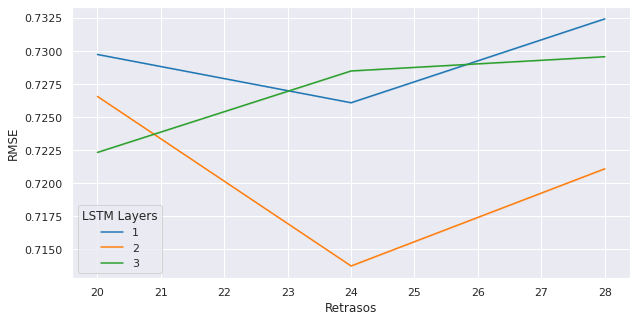

In [10]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Retrasos', y='RMSE',hue='LSTM Layers',palette='tab10',ci=0, estimator=np.min)

### Número de neuronas

El mejor número de neuronas es 100.

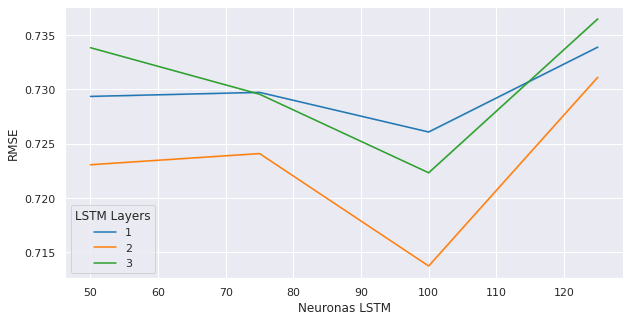

In [11]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Neuronas LSTM', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

### Batch Size

El mejor batch size se de 150.

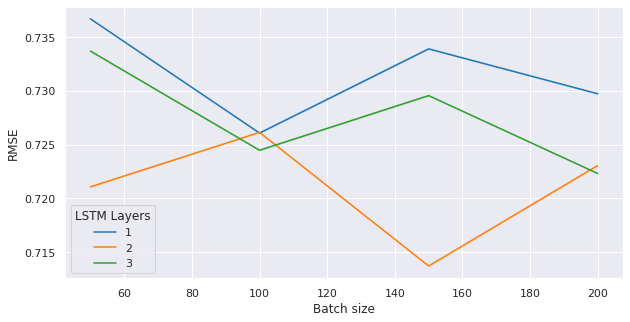

In [12]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Batch size', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

## Conclusiones

* 2 capas LSTM son mejor
* El mejor batch size es 150
* El mejor número de neuronas es 100
* El mejor número de retrasos es 24 (un día hacia atrás)